<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Objective" data-toc-modified-id="Objective-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Objective</a></span></li><li><span><a href="#Used-Python-Libraries" data-toc-modified-id="Used-Python-Libraries-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Used Python Libraries</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Example-Images" data-toc-modified-id="Example-Images-0.3.1"><span class="toc-item-num">0.3.1&nbsp;&nbsp;</span>Example Images</a></span></li></ul></li><li><span><a href="#Working-with-Image-Data" data-toc-modified-id="Working-with-Image-Data-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Working with Image Data</a></span><ul class="toc-item"><li><span><a href="#Preparing-Data" data-toc-modified-id="Preparing-Data-0.4.1"><span class="toc-item-num">0.4.1&nbsp;&nbsp;</span>Preparing Data</a></span><ul class="toc-item"><li><span><a href="#Feature-Reduction-with-PCA" data-toc-modified-id="Feature-Reduction-with-PCA-0.4.1.1"><span class="toc-item-num">0.4.1.1&nbsp;&nbsp;</span>Feature Reduction with PCA</a></span></li><li><span><a href="#PCA-Reconstruction-Examples" data-toc-modified-id="PCA-Reconstruction-Examples-0.4.1.2"><span class="toc-item-num">0.4.1.2&nbsp;&nbsp;</span>PCA Reconstruction Examples</a></span></li></ul></li></ul></li><li><span><a href="#XGBoost-Modeling---Bayesian-Hyperparameter-Optimization" data-toc-modified-id="XGBoost-Modeling---Bayesian-Hyperparameter-Optimization-0.5"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>XGBoost Modeling - Bayesian Hyperparameter Optimization</a></span></li><li><span><a href="#CNN---Using-VGGFace-Verification-Approach..." data-toc-modified-id="CNN---Using-VGGFace-Verification-Approach...-0.6"><span class="toc-item-num">0.6&nbsp;&nbsp;</span>CNN - Using VGGFace Verification Approach...</a></span></li><li><span><a href="#Kaggle-Submission" data-toc-modified-id="Kaggle-Submission-0.7"><span class="toc-item-num">0.7&nbsp;&nbsp;</span>Kaggle Submission</a></span></li></ul></li><li><span><a href="#NOTES-HERE-BELOW" data-toc-modified-id="NOTES-HERE-BELOW-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>NOTES HERE BELOW</a></span><ul class="toc-item"><li><span><a href="#T-SNE---Visualize-to-see-what-hyperparams-work-better" data-toc-modified-id="T-SNE---Visualize-to-see-what-hyperparams-work-better-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>T-SNE - Visualize to see what hyperparams work better</a></span></li><li><span><a href="#T-SNE-Fit" data-toc-modified-id="T-SNE-Fit-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>T-SNE Fit</a></span></li><li><span><a href="#Notes-on-Incremental-Learning" data-toc-modified-id="Notes-on-Incremental-Learning-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Notes on Incremental Learning</a></span></li></ul></li></ul></div>

## Objective

mmmm

[Back to Contents](#Table-of-Contents)

## Used Python Libraries

In [ ]:
# to make sure you use the latest version of kaggle:
!pip install --upgrade --force-reinstall --no-deps kaggle
# with an older version, not all files get downloaded

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Image loading and processing
import os
from PIL import Image
from PIL import Image, ImageDraw

# Modelng
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# utils
from progressbar import Percentage, ProgressBar,Bar,ETA
import glob
import kaggle

# Hyperparameter optimization
from hyperopt import hp, space_eval, STATUS_OK
import hyperopt
from functools import partial


[Back to Contents](#Table-of-Contents)

## Load Data

A table in csv format is provided to identify the expert diagnosis label and the associated image label.

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

In [ ]:
!mkdir data && unzip histopathologic-cancer-detection.zip -d data

In [ ]:
!rm histopathologic-cancer-detection.zip

In [2]:
training_labels_df = pd.read_csv('./data/train_labels.csv')
#training_labels_df = pd.read_csv('train_labels.csv')# in colab
print(training_labels_df.shape)
training_labels_df.sample(6)

(220025, 2)


,id,label
177952,588462c67bbac19753210f4b6f78c31223cb0f39,0
214780,b37ebfa92ecb68668290c018372eee26a9d9bd09,1
165283,ed864324918d88adc727fda3e45c3ca74f20ff81,1
44661,d5bd8b5ad4f8794190fc6749705a1cce5500c85b,1
203191,51844ed7fef217f6d5c15a7a4d8f3ba540d2fd4b,0
19047,b4521a58dcde0ae9c5779acb255f8a9994185040,0


In [3]:
# Any duplicated exemplar?
any(training_labels_df.duplicated())

False

In [4]:
pd.DataFrame({'label': training_labels_df['label'].value_counts(), 
              'label (perc.)': 100*training_labels_df['label'].value_counts()/len(training_labels_df)})

,label,label (perc.)
0,130908,59.496875
1,89117,40.503125


In [4]:
# image location
img_path ="./data/train"
# bounding box where identification neds to happen
ix1, iy1, ix2, iy2 = 47-16, 47-16, 47+16, 47+16

[Back to Contents](#Table-of-Contents)

### Example Images

In [5]:
def plot_images(label, img_path = "./data/train", rows_cols = (3,3), rnd_state=0):
    nrows, ncols=rows_cols[0], rows_cols[1]
    
    np.random.seed(rnd_state)
    imgs = np.random.choice(training_labels_df.loc[training_labels_df['label']==label]['id'].values, 
                            size=np.prod(rows_cols))
    fig,ax = plt.subplots(nrows,ncols,figsize=(10,10))
    fig.suptitle('Examples of Label=' + str(label) + ' Images', fontsize=25)
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(imgs[:nrows*ncols]):
        fname = os.path.join(img_path ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='red') # each image has 96pxx96px
        idcol.rectangle(((ix1,iy1),(ix2,iy2)),outline='green')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')  

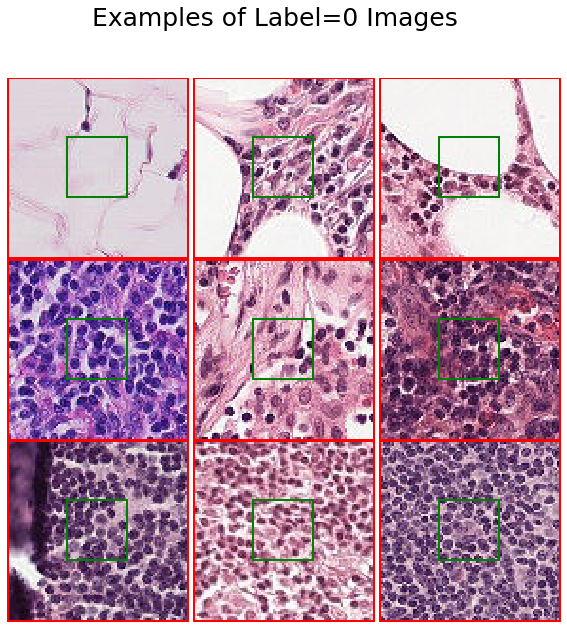

In [7]:
plot_images(0)

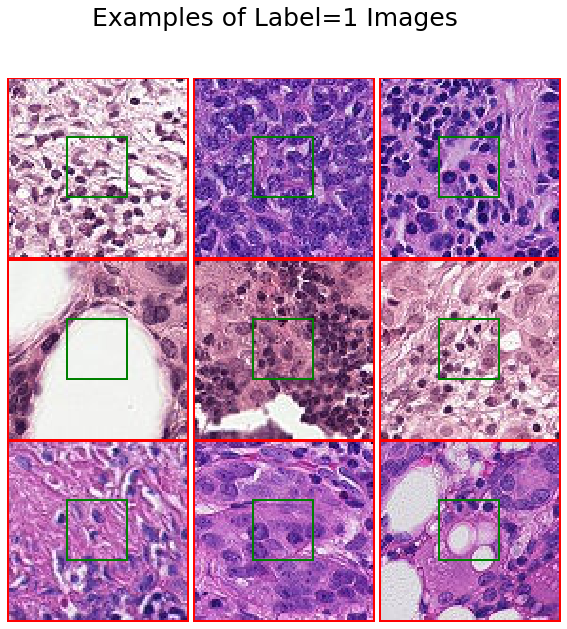

In [8]:
plot_images(1)

[Back to Contents](#Table-of-Contents)

## Working with Image Data

In [9]:
print('An image can be converted to an array of size:', 
      np.array(Image.open(os.path.join(img_path ,training_labels_df.iloc[0]['id'] +'.tif'))).shape)


An image can be converted to an array of size: (96, 96, 3)


Let's take two random images, one with label=1 and the other with label=0. Can we separate them ...?

In [10]:
np.random.seed(1)

imgs_0 = np.array(Image.open(os.path.join(img_path ,
                                          np.random.choice(training_labels_df.loc[training_labels_df['label']==0]['id'].values, size=1)[0]) +'.tif'))

imgs_1 = np.array(Image.open(os.path.join(img_path ,
                                          np.random.choice(training_labels_df.loc[training_labels_df['label']==1]['id'].values, size=1)[0]) +'.tif'))


In [11]:
np.ravel(imgs_0[ix1:ix2,iy1:iy2,1]).shape, np.ravel(imgs_1[ix1:ix2,iy1:iy2,1]).shape

print('When we consider the central part of the image of size', ix2-ix1, 'px X', iy2-iy1, 'px',
     'the size of one exemplar becomes', np.ravel(imgs_0[ix1:ix2,iy1:iy2,1]).shape)

When we consider the central part of the image of size 32 px X 32 px the size of one exemplar becomes (1024,)


### Preparing Data

In [6]:
def getBatchData(img_path, img_names, verbose=False):
    imgs_np = []
    if verbose:
        pbar = ProgressBar(widgets=[Bar('=', '[', ']'), ' ', Percentage(), ' ', ETA()],
                           maxval=len(img_names)).start()
    k = 0
    for i,j in enumerate(img_names):
        fname = os.path.join(img_path ,j +'.tif')
        img = Image.open(fname)
        imgs_np.append(np.ravel(np.array(img)[ix1:ix2,iy1:iy2,:])[:,None]/255.)
        k += 1
        if verbose:
            pbar.update(k)
    if verbose:
        pbar.finish()

    imgs_np = np.hstack(imgs_np).T
    
    return imgs_np

In [7]:
train_labels_df, test_labels_df = train_test_split(training_labels_df, test_size=0.25, 
                                                   stratify=training_labels_df.label, random_state=10)

train_labels_df.shape, test_labels_df.shape

((165018, 2), (55007, 2))

In [8]:
%%time

img_names = test_labels_df['id'].values
X_test = getBatchData("./data/train", img_names, verbose=True)
y_test = test_labels_df['label'].values   

X_test.shape

[==========================================================] 100% Time: 0:01:11


CPU times: user 21.4 s, sys: 11.2 s, total: 32.6 s
Wall time: 1min 14s


(55007, 3072)

In [9]:
%%time

img_names = train_labels_df['id'].values
X_train = getBatchData("./data/train", img_names, verbose=True)
y_train = train_labels_df['label'].values

X_train.shape

[==========================================================] 100% Time: 0:03:21


CPU times: user 1min 6s, sys: 38.7 s, total: 1min 45s
Wall time: 3min 48s


(165018, 3072)

#### Feature Reduction with PCA

We can use PCA to reduce the number of dimensions to a more reasonable amoun and suppress some
noise. We could later use T-SNE?

In [13]:
pca_pipeline = make_pipeline(StandardScaler(), PCA(0.95, random_state=2)) 
components = pca_pipeline.fit_transform(X_train)
print('original shape:', X_train.shape)
print('after PCA (95%)', components.shape)

original shape: (165018, 3072)
after PCA (95%) (165018, 700)


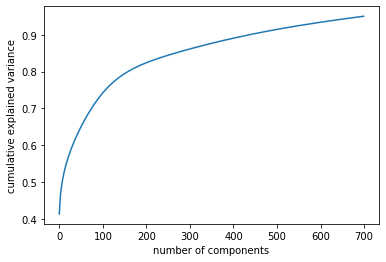

In [14]:
plt.plot(np.cumsum(pca_pipeline['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [15]:
components_test = pca_pipeline.transform(X_test)

#### PCA Reconstruction Examples

In [29]:
weights = compute_class_weight('balanced', np.unique(y_train), y_train)

# assign same probability to the two labels
p_0 = weights[0]
p_1 = weights[1]
p_s = np.array([p_0 if i==0 else p_1 for i in y_train])
p_s = p_s/np.sum(p_s)

# random sample of images
n_imgs = 1000 # limit for visualization
np.random.seed(1)
lbls_i_s = np.random.choice(range(len(train_labels_df['id'].values)), 
                          p = p_s,
                          size=n_imgs)

print('labels (counts):', np.unique(y_train[lbls_i_s], return_counts=True)[1])

labels (counts): [497 503]


/Users/atambu310/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[0 0 1 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


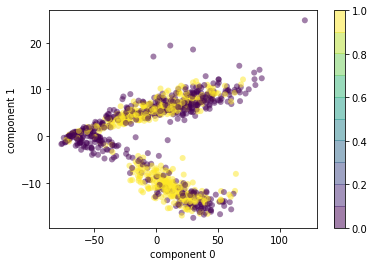

In [31]:
comps = (0,1)

plt.scatter(components[lbls_i_s, comps[0]], components[lbls_i_s, comps[1]],
            c=y_train[lbls_i_s], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component '+str(comps[0]))
plt.ylabel('component '+str(comps[1]))
plt.colorbar();

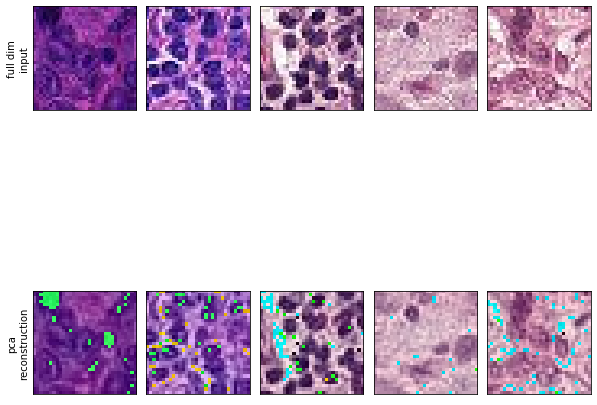

In [32]:
# Plot the PCA reconstruction
n_show = 5
projected = pca_pipeline.inverse_transform(components[lbls_i_s,:]) #reconstructed from components

fig, ax = plt.subplots(2, 5, figsize=(10, 10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(n_show):

    ax[0, i].imshow((255*X_train[lbls_i_s,:][i,:]).astype('uint8').reshape(32,32,3), cmap='binary_r')
    ax[1, i].imshow((255*projected[i]).astype('uint8').reshape(32,32,3), cmap='binary_r')
    
ax[0, 0].set_ylabel('full dim\ninput')
ax[1, 0].set_ylabel('pca\nreconstruction');


[Back to Contents](#Table-of-Contents)

## XGBoost Modeling - Bayesian Hyperparameter Optimization


In [49]:
def objective(space):
    
    print(space)
    
    # we use 10% of data to search the best parameters
    n_imgs = int(len(components)*0.1) 
    
    np.random.seed(1)
    lbls_i_s = np.random.choice(range(len(components)), 
                              p = p_s,
                              size=n_imgs)
    
    num_round = int(space['n_estimators'])
    dtrain = xgb.DMatrix(components[lbls_i_s,:], label=y_train[lbls_i_s])
    dvalid = xgb.DMatrix(components_test, label=y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm_model = xgb.train(space, dtrain, 
                          num_boost_round=num_round,
                          evals=watchlist,
                          early_stopping_rounds =10, 
                          verbose_eval=False)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = roc_auc_score(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    # Hyperopt minimizes...
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


space = {
    'n_estimators': hp.choice('n_estimators', [1000]),#hp.quniform('n_estimators', 100, 1000, 1)
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'learning_rate':  hp.choice('learning_rate', [0.001, 0.01, 0.1, 1]),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'reg_lambda': hp.choice('reg_lambda', [0,1,10,100,1000]),#l2
    'gamma': hp.choice('gamma', [0,1,10,100,1000]), #l1
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    # Increase this number if you have more cores. Otherwise, remove it and it will default 
    # to the maxium number. 
    'nthread': 4,
    'booster': 'gbtree',
    'tree_method': 'exact',
    'silent': 1,
    'seed': 0,
    
}


# Object stores all information about each trial.
# Also, it stores information about the best trial.
trials = hyperopt.Trials()

tpe = partial(
    hyperopt.tpe.suggest,

    # Sample 1000 candidate and select candidate that
    # has highest Expected Improvement
    n_EI_candidates=1000,

    # Use 20% of best observations to estimate next
    # set of parameters
    gamma=0.2,

    # First 20 trials are going to be random
    n_startup_jobs=20
)

best_trial = hyperopt.fmin(
    objective,

    trials=trials,
    space=space,

    # Set up TPE for hyperparameter optimization
    algo=tpe,

    # Maximum number of iterations. Basically it trains at
    # most 200 networks before selecting the best one.
    max_evals=100
)

{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.1, 'eval_metric': 'auc', 'gamma': 10, 'learning_rate': 0.001, 'max_depth': 8, 'min_child_weight': 3.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 10, 'seed': 0, 'silent': 1, 'subsample': 0.9, 'tree_method': 'exact'}
	Score 0.8162183335245129                            


{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.05, 'eval_metric': 'auc', 'gamma': 1000, 'learning_rate': 1, 'max_depth': 6, 'min_child_weight': 6.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 10, 'seed': 0, 'silent': 1, 'subsample': 0.8500000000000001, 'tree_method': 'exact'}
	Score 0.7189400388305649                                                       


{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.325, 'eval_metric': 'auc', 'gamma': 1000, 'learning_rate': 1, 'max_depth': 8, 'min_child_weight': 5.0, 'n_estimators': 1000, 'nthread': 4, 'objective': '

	Score 0.7879051531743015                                                             


{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.42500000000000004, 'eval_metric': 'auc', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 4.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 100, 'seed': 0, 'silent': 1, 'subsample': 0.65, 'tree_method': 'exact'}
	Score 0.8182988577941919                                                             


{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.375, 'eval_metric': 'auc', 'gamma': 10, 'learning_rate': 1, 'max_depth': 2, 'min_child_weight': 6.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 1, 'seed': 0, 'silent': 1, 'subsample': 0.6000000000000001, 'tree_method': 'exact'}
	Score 0.814338723992658                                                              


{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta

	Score 0.7835690649631337                                                               


{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.2, 'eval_metric': 'auc', 'gamma': 10, 'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 2.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 0, 'seed': 0, 'silent': 1, 'subsample': 1.0, 'tree_method': 'exact'}
	Score 0.7840316810265262                                                               


{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.07500000000000001, 'eval_metric': 'auc', 'gamma': 10, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 0, 'seed': 0, 'silent': 1, 'subsample': 0.8500000000000001, 'tree_method': 'exact'}
	Score 0.856637032605134                                                              


{'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.15000000

	Score 0.8322712837263869                                                             


{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.325, 'eval_metric': 'auc', 'gamma': 1000, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 1000, 'seed': 0, 'silent': 1, 'subsample': 0.75, 'tree_method': 'exact'}
	Score 0.6973731226211246                                                             


{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.4, 'eval_metric': 'auc', 'gamma': 10, 'learning_rate': 1, 'max_depth': 4, 'min_child_weight': 2.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_lambda': 100, 'seed': 0, 'silent': 1, 'subsample': 0.9, 'tree_method': 'exact'}
	Score 0.8264552074314364                                                           


{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.1, 'eval_metric': 'auc'

	Score 0.8223143911447617                                                           


100%|██████████| 100/100 [47:52:43<00:00, 1723.64s/it, best loss: 0.13528864803925233]


In [50]:
param_dist = space_eval(space, best_trial)
param_dist

{'booster': 'gbtree',
 'colsample_bytree': 0.8,
 'eta': 0.2,
 'eval_metric': 'auc',
 'gamma': 10,
 'learning_rate': 0.01,
 'max_depth': 12,
 'min_child_weight': 2.0,
 'n_estimators': 1000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_lambda': 0,
 'seed': 0,
 'silent': 1,
 'subsample': 0.8,
 'tree_method': 'exact'}

In [51]:
import pprint

pp = pprint.PrettyPrinter(indent=4)

trials_results = {}
trials_vals = {}
trials_nodes = {}
for i in range(len(trials.trials)):
    trials_results[i] = trials.trials[i]['result']['loss']
    trials_vals[i] = trials.trials[i]['misc']['vals']
    pp.pprint(trials.trials[i]["result"])

{'loss': 0.1837816664754871, 'status': 'ok'}
{'loss': 0.2810599611694351, 'status': 'ok'}
{'loss': 0.28067151220375475, 'status': 'ok'}
{'loss': 0.20149728269977762, 'status': 'ok'}
{'loss': 0.14474533460230454, 'status': 'ok'}
{'loss': 0.1417868197101323, 'status': 'ok'}
{'loss': 0.2285010780111777, 'status': 'ok'}
{'loss': 0.17487932169283138, 'status': 'ok'}
{'loss': 0.1435960733918742, 'status': 'ok'}
{'loss': 0.20898962770131602, 'status': 'ok'}
{'loss': 0.20400754673653798, 'status': 'ok'}
{'loss': 0.13771446324989078, 'status': 'ok'}
{'loss': 0.5, 'status': 'ok'}
{'loss': 0.13986495113621256, 'status': 'ok'}
{'loss': 0.20581212584561293, 'status': 'ok'}
{'loss': 0.22082863201747505, 'status': 'ok'}
{'loss': 0.1537617240092799, 'status': 'ok'}
{'loss': 0.15452048045692623, 'status': 'ok'}
{'loss': 0.21145366990366243, 'status': 'ok'}
{'loss': 0.20930290841392352, 'status': 'ok'}
{'loss': 0.15091101572066268, 'status': 'ok'}
{'loss': 0.14132116589451527, 'status': 'ok'}
{'loss': 0

In [52]:
dtrain = xgb.DMatrix(components, label=y_train)
dvalid = xgb.DMatrix(components_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm_model = xgb.train(param_dist, 
                      dtrain, 
                      num_boost_round = int(param_dist['n_estimators']),
                      evals=watchlist,
                      early_stopping_rounds =10, 
                      verbose_eval=True)

[0]	train-auc:0.824956	eval-auc:0.761904
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.882987	eval-auc:0.820704
[2]	train-auc:0.890709	eval-auc:0.825624
[3]	train-auc:0.898998	eval-auc:0.835948
[4]	train-auc:0.901476	eval-auc:0.84039
[5]	train-auc:0.903366	eval-auc:0.842623
[6]	train-auc:0.905121	eval-auc:0.843516
[7]	train-auc:0.90558	eval-auc:0.844127
[8]	train-auc:0.907418	eval-auc:0.845981
[9]	train-auc:0.908832	eval-auc:0.846945
[10]	train-auc:0.909612	eval-auc:0.848047
[11]	train-auc:0.910203	eval-auc:0.849131
[12]	train-auc:0.910894	eval-auc:0.849886
[13]	train-auc:0.911172	eval-auc:0.850233
[14]	train-auc:0.912222	eval-auc:0.850972
[15]	train-auc:0.912497	eval-auc:0.851394
[16]	train-auc:0.913303	eval-auc:0.851837
[17]	train-auc:0.913715	eval-auc:0.852253
[18]	train-auc:0.914441	eval-auc:0.852442
[19]	train-auc:0.914502	eval-auc:0.852314
[20]	train-auc:0.914898	eval-au

[191]	train-auc:0.941449	eval-auc:0.867092
[192]	train-auc:0.941568	eval-auc:0.867173
[193]	train-auc:0.941684	eval-auc:0.867227
[194]	train-auc:0.941822	eval-auc:0.86732
[195]	train-auc:0.941976	eval-auc:0.867398
[196]	train-auc:0.942083	eval-auc:0.867422
[197]	train-auc:0.942165	eval-auc:0.867487
[198]	train-auc:0.942273	eval-auc:0.867552
[199]	train-auc:0.942463	eval-auc:0.867665
[200]	train-auc:0.942616	eval-auc:0.867743
[201]	train-auc:0.942741	eval-auc:0.8678
[202]	train-auc:0.942832	eval-auc:0.867816
[203]	train-auc:0.942934	eval-auc:0.867858
[204]	train-auc:0.943027	eval-auc:0.8679
[205]	train-auc:0.943135	eval-auc:0.867933
[206]	train-auc:0.943234	eval-auc:0.867951
[207]	train-auc:0.943359	eval-auc:0.867997
[208]	train-auc:0.943477	eval-auc:0.868029
[209]	train-auc:0.943645	eval-auc:0.868106
[210]	train-auc:0.943746	eval-auc:0.868135
[211]	train-auc:0.943856	eval-auc:0.868188
[212]	train-auc:0.943969	eval-auc:0.868219
[213]	train-auc:0.944034	eval-auc:0.86825
[214]	train-auc:0

[383]	train-auc:0.956742	eval-auc:0.875136
[384]	train-auc:0.9568	eval-auc:0.875179
[385]	train-auc:0.956872	eval-auc:0.875229
[386]	train-auc:0.95694	eval-auc:0.87529
[387]	train-auc:0.956983	eval-auc:0.875312
[388]	train-auc:0.957065	eval-auc:0.875358
[389]	train-auc:0.957099	eval-auc:0.875369
[390]	train-auc:0.957147	eval-auc:0.875387
[391]	train-auc:0.957193	eval-auc:0.875432
[392]	train-auc:0.957271	eval-auc:0.87549
[393]	train-auc:0.957338	eval-auc:0.875538
[394]	train-auc:0.957386	eval-auc:0.875571
[395]	train-auc:0.957464	eval-auc:0.875636
[396]	train-auc:0.957522	eval-auc:0.87566
[397]	train-auc:0.957574	eval-auc:0.875683
[398]	train-auc:0.957667	eval-auc:0.875737
[399]	train-auc:0.957722	eval-auc:0.875776
[400]	train-auc:0.95777	eval-auc:0.875791
[401]	train-auc:0.957825	eval-auc:0.875844
[402]	train-auc:0.957906	eval-auc:0.875894
[403]	train-auc:0.957961	eval-auc:0.875932
[404]	train-auc:0.958034	eval-auc:0.875986
[405]	train-auc:0.958067	eval-auc:0.876007
[406]	train-auc:0.

[575]	train-auc:0.966172	eval-auc:0.880804
[576]	train-auc:0.966197	eval-auc:0.880814
[577]	train-auc:0.966237	eval-auc:0.88084
[578]	train-auc:0.966276	eval-auc:0.880856
[579]	train-auc:0.966307	eval-auc:0.88086
[580]	train-auc:0.96635	eval-auc:0.880893
[581]	train-auc:0.966381	eval-auc:0.880916
[582]	train-auc:0.96642	eval-auc:0.880939
[583]	train-auc:0.966449	eval-auc:0.880955
[584]	train-auc:0.966459	eval-auc:0.880967
[585]	train-auc:0.966484	eval-auc:0.880977
[586]	train-auc:0.966537	eval-auc:0.881007
[587]	train-auc:0.966567	eval-auc:0.88102
[588]	train-auc:0.966593	eval-auc:0.88103
[589]	train-auc:0.966632	eval-auc:0.881057
[590]	train-auc:0.966675	eval-auc:0.881078
[591]	train-auc:0.96671	eval-auc:0.881085
[592]	train-auc:0.966745	eval-auc:0.881113
[593]	train-auc:0.966792	eval-auc:0.881147
[594]	train-auc:0.966815	eval-auc:0.881159
[595]	train-auc:0.966836	eval-auc:0.881182
[596]	train-auc:0.966877	eval-auc:0.881206
[597]	train-auc:0.96691	eval-auc:0.881222
[598]	train-auc:0.9

[772]	train-auc:0.971891	eval-auc:0.884068
[773]	train-auc:0.971901	eval-auc:0.884081
[774]	train-auc:0.971927	eval-auc:0.8841
[775]	train-auc:0.971941	eval-auc:0.884107
[776]	train-auc:0.971961	eval-auc:0.884119
[777]	train-auc:0.971989	eval-auc:0.884128
[778]	train-auc:0.972033	eval-auc:0.884153
[779]	train-auc:0.972069	eval-auc:0.884184
[780]	train-auc:0.972088	eval-auc:0.884191
[781]	train-auc:0.972116	eval-auc:0.884213
[782]	train-auc:0.972124	eval-auc:0.884216
[783]	train-auc:0.972152	eval-auc:0.884232
[784]	train-auc:0.972155	eval-auc:0.884238
[785]	train-auc:0.972177	eval-auc:0.884242
[786]	train-auc:0.972192	eval-auc:0.884248
[787]	train-auc:0.972214	eval-auc:0.884258
[788]	train-auc:0.972249	eval-auc:0.884279
[789]	train-auc:0.972269	eval-auc:0.884286
[790]	train-auc:0.972283	eval-auc:0.884303
[791]	train-auc:0.972325	eval-auc:0.884321
[792]	train-auc:0.972385	eval-auc:0.884348
[793]	train-auc:0.972402	eval-auc:0.884361
[794]	train-auc:0.97245	eval-auc:0.884392
[795]	train-au

[964]	train-auc:0.975484	eval-auc:0.886065
[965]	train-auc:0.975517	eval-auc:0.886093
[966]	train-auc:0.975527	eval-auc:0.8861
[967]	train-auc:0.975537	eval-auc:0.8861
[968]	train-auc:0.975547	eval-auc:0.886103
[969]	train-auc:0.975596	eval-auc:0.886136
[970]	train-auc:0.975609	eval-auc:0.886146
[971]	train-auc:0.97562	eval-auc:0.88615
[972]	train-auc:0.975645	eval-auc:0.886161
[973]	train-auc:0.975649	eval-auc:0.886165
[974]	train-auc:0.975663	eval-auc:0.886164
[975]	train-auc:0.975676	eval-auc:0.886168
[976]	train-auc:0.97569	eval-auc:0.886168
[977]	train-auc:0.975711	eval-auc:0.886182
[978]	train-auc:0.975714	eval-auc:0.886184
[979]	train-auc:0.97572	eval-auc:0.886187
[980]	train-auc:0.975718	eval-auc:0.886188
[981]	train-auc:0.975722	eval-auc:0.886193
[982]	train-auc:0.975736	eval-auc:0.8862
[983]	train-auc:0.975789	eval-auc:0.886227
[984]	train-auc:0.9758	eval-auc:0.886233
[985]	train-auc:0.97581	eval-auc:0.886247
[986]	train-auc:0.975823	eval-auc:0.886254
[987]	train-auc:0.975838

In [53]:
predictions = gbm_model.predict(dvalid,
                                ntree_limit=gbm_model.best_iteration + 1)
score = roc_auc_score(y_test, predictions)
print("\tScore {0}\n\n".format(score))

	Score 0.8863951558014429




In [54]:
import pickle

# save the model to disk
filename = 'gbm_model.sav'
pickle.dump(gbm_model, open(filename, 'wb'))
 

In [ ]:
# load the model from disk
filename = 'gbm_model.sav'
gbm_model = pickle.load(open(filename, 'rb'))

## CNN - Using VGGFace Verification Approach...

According to this [paper](https://papers.nips.cc/paper/2019/file/eb1e78328c46506b46a4ac4a1e378b91-Paper.pdf):
"transfer learning offers limited performance gains and much smaller architectures can perform
comparably to the standard IMAGENET models". However, substantial gain in terms of speeding the computation arises when "Use the pretrained weights only from the lowest two layers. The rest of the network is randomly initialized and fine-tuned for the medical imaging task." (see [here](https://theaisummer.com/medical-imaging-transfer-learning/) for example)

Face verification...

In [ ]:
#!pip install -U efficientnet

In [65]:
from keras.applications import vgg16 
import efficientnet.keras as efn

#from keras.applications.vgg16 import decode_predictions
#from keras.preprocessing.image import load_img, img_to_array
#from keras.applications.imagenet_utils import preprocess_input
#from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Flatten, Dense, Dropout
from keras.backend import clear_session

from keras.optimizers import Adam

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from keras import Model, Sequential

from keras.models import load_model, save_model 

In [105]:
# original model
base_model = efn.EfficientNetB0(weights='imagenet', #using pre-trained weights
                       )
base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

The EFN model was trained to classify 1000 different images. We remove the classification/softmax layer containing 1000 units. Also, the input needs to accept our input format. To fine tune, we ned to keep all layers trainable but here we're just training to classify our images.

In [106]:
clear_session()
base_model = efn.EfficientNetB0(weights='imagenet', #using pre-trained weights
                        input_shape=(96, 96, 3),
                        include_top=False # rm thee last fully connected layer
                       )

for layer in base_model.layers:
    layer.trainable = False
    
# print the layers of the CNN
base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 48, 48, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 48, 48, 32)   0           stem_bn[0][0]                    
____________________________________________________________________________________

In [107]:
x = base_model.output
# Flatten the output layer to 1 dimension
x = Flatten()(x)
# Add a fully connected layer with 1024 hidden units and ReLU activation
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
out = Dense(1, activation="sigmoid")(x)
custom_base_model = Model(base_model.input, out)

custom_base_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 48, 48, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 48, 48, 32)   0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [108]:
for layer in custom_base_model.layers:
    print(layer, layer.trainable)


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe3fa673128> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe3fa6732b0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe3fa673898> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fe3fa673ef0> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7fe3fa673550> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe3e96b6ef0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fe3e96adeb8> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fe3e96ad7f0> False
<tensorflow.python.keras.layers.core.Reshape object at 0x7fe3e96a7748> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe3fa6c7710> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe3fa6ccf98> False
<tensorflow.python.keras.layers.

In [83]:
#Replace with generator, flow from directory and augmentation,...
def getImageData(img_path, img_names, verbose=False):        
        
    imgs = []
    if verbose:
        pbar = ProgressBar(widgets=[Bar('=', '[', ']'), ' ', Percentage(), ' ', ETA()],
                           maxval=len(img_names)).start()
    k = 0
    for i,j in enumerate(img_names):
        fname = os.path.join(img_path ,j +'.tif')
        img = np.asarray(Image.open(fname), dtype=np.float32) # for drawing
        # reusing pretrained models with pooling requires a minumum number of pixels.
        # we keep all pixels but we set those outside of the interest region to 0
        img = img.copy() # without cpying I can't crop...
        img[:ix1,:,:] = 0. 
        img[:,:iy1,:] = 0. 
        img[ix2:,:,:] = 0. 
        img[:,iy2:,:] = 0. 
        imgs.append(img[None,:,:,:]/255.)# None needed to keep first dimension when concatenating
        k += 1
        if verbose:
            pbar.update(k)
    if verbose:
        pbar.finish()

    #imgs_np = preprocess_input(imgs)
    imgs_np = np.concatenate(imgs, axis=0)
    
    return imgs_np

In [51]:
img_names = train_labels_df['id'].values

X_train = getImageData("./data/train", img_names, verbose=True)
X_train.shape

[==========================================================] 100% Time: 0:03:38


(165018, 96, 96, 3)

In [52]:
img_names = test_labels_df['id'].values

X_test = getImageData("./data/train", img_names, verbose=True)
X_test.shape

[==========================================================] 100% Time: 0:01:10


(55007, 96, 96, 3)

In [206]:
#NOTES:
#Image.fromarray(X_train[0], 'RGB') #must be np.int8 to draw and not normalized if you want to check cropping
#plt.imshow(np.array(Image.open(os.path.join(img_path ,img_names[0] +'.tif'))))

In [56]:
# for testing purposes, sample fewer images
i_s, _ = train_test_split(np.arange(0,len(y_train)), train_size=1000,
                          stratify=y_train, random_state=10)

i_s1, _ = train_test_split(np.arange(0,len(y_test)), train_size=1000,
                          stratify=y_test, random_state=20)


In [57]:
np.unique(y_train[i_s], return_counts=True), np.unique(y_test[i_s1], return_counts=True)

((array([0, 1]), array([595, 405])), (array([0, 1]), array([595, 405])))

In [109]:
custom_base_model.compile(loss="binary_crossentropy", optimizer=Adam(), 
                         metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, 
                   restore_best_weights=True, 
                   patience=10)
                
batch_size = 512
n_epochs = 50
#custom_base_model_history = custom_base_model.fit(X_train[i_s], 
#                                                y_train[i_s],
#                                                validation_data=(X_test[i_s1], y_test[i_s1]),
#                                                batch_size = batch_size,
#                                                epochs=n_epochs, callbacks=[es])
custom_base_model_history = custom_base_model.fit(X_train, 
                                                y_train,
                                                validation_data=(X_test, y_test),
                                                batch_size = batch_size,
                                                epochs=n_epochs, callbacks=[es])


Epoch 1/50
323/323 [==============================] - 1133s 4s/step - loss: 0.5547 - accuracy: 0.7642 - val_loss: 0.4619 - val_accuracy: 0.7851
Epoch 2/50
323/323 [==============================] - 1136s 4s/step - loss: 0.4729 - accuracy: 0.7815 - val_loss: 0.4600 - val_accuracy: 0.7884
Epoch 3/50
323/323 [==============================] - 1137s 4s/step - loss: 0.4685 - accuracy: 0.7857 - val_loss: 0.4521 - val_accuracy: 0.7888
Epoch 4/50
323/323 [==============================] - 33553s 104s/step - loss: 0.4657 - accuracy: 0.7863 - val_loss: 0.4572 - val_accuracy: 0.7858
Epoch 5/50
323/323 [==============================] - 1141s 4s/step - loss: 0.4640 - accuracy: 0.7875 - val_loss: 0.4463 - val_accuracy: 0.7924
Epoch 6/50
323/323 [==============================] - 1134s 4s/step - loss: 0.4633 - accuracy: 0.7875 - val_loss: 0.4456 - val_accuracy: 0.7938
Epoch 7/50
323/323 [==============================] - 1152s 4s/step - loss: 0.4619 - accuracy: 0.7886 - val_loss: 0.4588 - val_accura

In [110]:
for layer in base_model.layers:
    layer.trainable = True
    
for layer in custom_base_model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe3fa673128> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe3fa6732b0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe3fa673898> True
<tensorflow.python.keras.layers.core.Activation object at 0x7fe3fa673ef0> True
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7fe3fa673550> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe3e96b6ef0> True
<tensorflow.python.keras.layers.core.Activation object at 0x7fe3e96adeb8> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fe3e96ad7f0> True
<tensorflow.python.keras.layers.core.Reshape object at 0x7fe3e96a7748> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe3fa6c7710> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe3fa6ccf98> True
<tensorflow.python.keras.layers.merge.Multi

In [111]:
custom_base_model_history = custom_base_model.fit(X_train, 
                                                y_train,
                                                validation_data=(X_test, y_test),
                                                batch_size = batch_size,
                                                epochs=n_epochs, callbacks=[es])


Epoch 1/50
323/323 [==============================] - 1147s 4s/step - loss: 0.4379 - accuracy: 0.8016 - val_loss: 0.4260 - val_accuracy: 0.8040
Epoch 2/50
323/323 [==============================] - 1143s 4s/step - loss: 0.4389 - accuracy: 0.8023 - val_loss: 0.4242 - val_accuracy: 0.8050
Epoch 3/50
323/323 [==============================] - 1137s 4s/step - loss: 0.4372 - accuracy: 0.8029 - val_loss: 0.4258 - val_accuracy: 0.8054
Epoch 4/50
323/323 [==============================] - 1138s 4s/step - loss: 0.4366 - accuracy: 0.8036 - val_loss: 0.4215 - val_accuracy: 0.8063
Epoch 5/50
323/323 [==============================] - 1138s 4s/step - loss: 0.4365 - accuracy: 0.8028 - val_loss: 0.4278 - val_accuracy: 0.8033
Epoch 6/50
323/323 [==============================] - 1150s 4s/step - loss: 0.4372 - accuracy: 0.8023 - val_loss: 0.4246 - val_accuracy: 0.8058
Epoch 7/50
323/323 [==============================] - 1140s 4s/step - loss: 0.4364 - accuracy: 0.8031 - val_loss: 0.4232 - val_accuracy:

In [ ]:
clear_session()

custom_base_model = Sequential()
custom_base_model.add(Dense(300, activation='relu', activity_regularizer=regularizers.l2(1e-3)))
custom_base_model.add(Dense(150, activation='relu', activity_regularizer=regularizers.l2(1e-3)))
custom_base_model.add(Dense(75, activation='relu', activity_regularizer=regularizers.l2(1e-3)))
custom_base_model.add(Dense(30, activation='relu'))
custom_base_model.add(Dense(2, activation='softmax'))

keras_pipeline = make_pipeline(StandardScaler())
keras_X_train = keras_pipeline.fit_transform(components)
keras_X_test = keras_pipeline.transform(components_test)


custom_vgg_model.compile(loss="categorical_crossentropy", optimizer=Adam(), 
                         metrics=["AUC"])


es = EarlyStopping(monitor='val_loss', verbose=0, 
                   restore_best_weights=True, 
                   patience=10)
                
batch_size = 100
n_epochs = 50
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
custom_base_model_history = custom_base_model.fit(keras_X_train, 
                                                to_categorical(y_train),
                                                validation_data=(keras_X_test, to_categorical(y_test)),
                                                batch_size = batch_size,
                                                epochs=n_epochs, callbacks=[es])


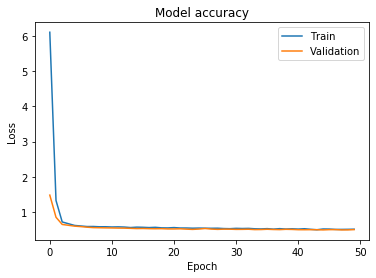

In [77]:
plt.plot(custom_base_model_history.history['loss'])
plt.plot(custom_base_model_history.history['val_loss'])
plt.title('Model accuracy')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Kaggle Submission

https://www.kaggle.com/c/histopathologic-cancer-detection/leaderboard

In [79]:
subm_imgs = [i.replace('./data/test/','').replace('.tif','') for i in glob.glob("./data/test/*.tif")]
subm_imgs[:10]

['fd0a060ef9c30c9a83f6b4bfb568db74b099154d',
 '1f9ee06f06d329eb7902a2e03ab3835dd0484581',
 '19709bec800f372d0b1d085da6933dd3ef108846',
 '7a34fc34523063f13f0617f7518a0330f6187bd3',
 '93be720ca2b95fe2126cf2e1ed752bd759e9b0ed',
 '761dde7de22cb39a0dd67ce472163d66e5ac1568',
 '58055ce8819717a100b48d019e139be4fdf997c0',
 '9735b584631f4b942b022d40aecdbe2aa8f6ae5e',
 '860bbd33f8483a45858c4998021bc7434117deda',
 '99050fbce64ae16e48e8a3b09d38f3b16df63fbe']

In [ ]:
### GBM

In [56]:
subm_imgs_np = getBatchData('./data/test/', subm_imgs, True)

subm_imgs_np.shape

[==========================================================] 100% Time: 0:01:06


(57458, 3072)

In [58]:
components_subm = pca_pipeline.transform(subm_imgs_np)

In [59]:
dsubm = xgb.DMatrix(components_subm, label=None)

subm_preds = gbm_model.predict(dsubm,
                               ntree_limit=gbm_model.best_iteration + 1) #0.8767 on Leaderboard

In [60]:
pd.DataFrame({'id': subm_imgs, 'label': subm_preds}).to_csv('./data/submission_gbm.csv', index=False)

In [ ]:
### NN

In [84]:
subm_imgs_np = getImageData("./data/test/", subm_imgs, verbose=True)

subm_imgs_np.shape

[==========================================================] 100% Time: 0:01:12


(57458, 96, 96, 3)

In [85]:
subm_preds = custom_base_model.predict(subm_imgs_np, use_multiprocessing=True, verbose=1) # on Leaderboard

1796/1796 [==============================] - 328s 183ms/step


In [96]:
pd.DataFrame({'id': subm_imgs, 
              'label': (subm_preds>0.5).astype('int').reshape(-1)}).to_csv('./data/submission_efn.csv', index=False)

# NOTES HERE BELOW

## T-SNE - Visualize to see what hyperparams work better

In [ ]:
import tensorflow as tf
from tensorboard.plugins import projector

## Get working directory
PATH = os.getcwd()
## Path to save the embedding and checkpoints generated
LOG_DIR = PATH + '/project-tensorboard/'
os.mkdir(LOG_DIR)
LOG_DIR = PATH + '/project-tensorboard/log-1'
os.mkdir(LOG_DIR)

In [17]:
def register_embedding(embedding_tensor_name, meta_data_fname, log_dir):
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_tensor_name
    embedding.metadata_path = meta_data_fname
    projector.visualize_embeddings(log_dir, config)

def save_labels_tsv(labels, filepath, log_dir):
    with open(os.path.join(log_dir, filepath), 'w') as f:
        for label in labels:
            f.write('{}\n'.format(label))

In [18]:
META_DATA_FNAME = 'labels.tsv'  # Labels will be stored here
EMBEDDINGS_TENSOR_NAME = 'labels'
EMBEDDINGS_FPATH = os.path.join(LOG_DIR, EMBEDDINGS_TENSOR_NAME + '.ckpt')
STEP = 0

register_embedding(EMBEDDINGS_TENSOR_NAME, META_DATA_FNAME, LOG_DIR)
save_labels_tsv(y_train[:10000], META_DATA_FNAME, LOG_DIR)

In [19]:
tf.compat.v1.disable_eager_execution()
tensor_embeddings = tf.Variable(components[:10000], name=EMBEDDINGS_TENSOR_NAME)
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())
saver = tf.compat.v1.train.Saver()
saver.save(sess, EMBEDDINGS_FPATH, STEP)
sess.close()

In [23]:
np.unique(y_train[:10000], return_counts=True)

(array([0, 1]), array([5954, 4046]))

In [83]:
!kill 49657

In [20]:
%load_ext tensorboard

In [21]:
%tensorboard --logdir project-tensorboard/log-1

Reusing TensorBoard on port 6007 (pid 49657), started 1:18:50 ago. (Use '!kill 49657' to kill it.)

## T-SNE Fit

In [ ]:
from sklearn.manifold import TSNE

fashion_tsne = TSNE(random_state=1).fit_transform(X_train)


In [ ]:
model = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, 
                               class_weight='balanced', random_state=42, n_jobs=-1)  
model.fit(X_train, y_train)


In [ ]:
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    auc   = roc_auc_score(y_test, y_pred)
    acc   = accuracy(y_test, y_pred)
    rec   = recall(y_test, y_pred)
    prec  = precision(y_test, y_pred)
    f1    = f1_score(y_test, y_pred)
    
    print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}, AUC = {auc}')
    print('Confusion Matrix is:')
    print(cm)


In [ ]:
pca_pipeline = make_pipeline(StandardScaler(), PCA(0.95, random_state=2)) 
components = pca_pipeline.fit_transform(X_train)
projected = pca_pipeline.inverse_transform(components)
print('original shape:', X_train.shape)
print('after PCA (95%)', components.shape)

In [ ]:
model = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, 
                               class_weight='balanced', random_state=42, n_jobs=-1)  
model.fit(components, y_train)


In [ ]:
    y_pred = model.predict(pca_pipeline.transform(X_test))
    
    cm = confusion_matrix(y_test, y_pred)
    auc   = roc_auc_score(y_test, y_pred)
    acc   = accuracy(y_test, y_pred)
    rec   = recall(y_test, y_pred)
    prec  = precision(y_test, y_pred)
    f1    = f1_score(y_test, y_pred)
    
    print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}, AUC = {auc}')
    print('Confusion Matrix is:')
    print(cm)


In [ ]:
# create random batches from **training data**
n_splits = 100
max_batch_size = 1000

# assign same probability to be picked 
weights = compute_class_weight('balanced', np.unique(train_labels_df.label), train_labels_df.label)
p_0 = weights[0]
p_1 = weights[1]
p_s = np.array([p_0 if i==0 else p_1 for i in train_labels_df['label']])
p_s = p_s/np.sum(p_s)

print('Generating', n_splits, 'balanced random batches of size', max_batch_size)

## Notes on Incremental Learning

In [ ]:
#results = {}

results = {}
batch_improvements = []
n_estimators = 5
model = None
best_model = None
auc_best = -1
k = 0
for i in range(n_splits):
    lbls_i_s = np.random.choice(range(len(train_labels_df['id'].values)), 
                              p = p_s,
                              size=max_batch_size)
    
    print('-->Batch:', k)
    #print('Ratios for 0/1 labels:', np.unique(lbls_s, return_counts=True)[1]/len(lbls_s))
    
    #training batch
    img_names = [train_labels_df['id'].values[i] for i in lbls_i_s]
    print('Getting batch...')
    X_train = getBatchData(img_names)
    y_train = [train_labels_df['label'].values[i] for i in lbls_i_s]
    print('...done')
     
    #feature reduction
    print('PCA...')
    pca_pipeline = make_pipeline(StandardScaler(), PCA(100, random_state=2)) #fix number of features
    X_train = pca_pipeline.fit_transform(X_train)
    ##pca transformation changes from batch to batch, so update test set accordingly
    X_test_tmp = pca_pipeline.transform(X_test)
    print('...done')
    
    #train model
    print('Model training...')
    
    #xgboost
    #dtrain = xgb.DMatrix(X_train, y_train)
    #dtest = xgb.DMatrix(X_test_tmp, y_test)
    #model_tmp = xgb.train({
    #            'learning_rate': 0.1,
    #            'eval_metric': 'auc',
    #            'seed': 42,
    #            'updater':'refresh',
    #            'process_type': 'update',
    #            'refresh_leaf': True,
    #            'silent': False
    #}, 
    #        dtrain=dtrain, 
    #        evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
    #        early_stopping_rounds=5,
    #        xgb_model=model)   

    #model_tmp = XGBClassifier(objective="binary:logistic", 
    #                          eval_metric="auc",
    #                          n_jobs=-1,
    #                          xgb_model=model, #keep updating model
    #                          random_state=42)
    #model_tmp.fit(X_train,y_train, early_stopping_rounds=5, eval_set=[(X_test_tmp, y_test)], verbose=0)
    
    # Update model with newly trained estimators using this batch
    if model is None:
        model = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=3, 
                                       class_weight='balanced', random_state=42, n_jobs=-1)  
        model.fit(X_train, y_train)
    else:
        model_tmp = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=3, 
                                       class_weight='balanced', random_state=42, n_jobs=-1)  
        model_tmp.fit(X_train, y_train)
        model.estimators_ += model_tmp.estimators_
        model.n_estimators = len(model.estimators_)
    
    print('...done')
    #y_pred = model_tmp.predict(X_test_tmp)
    #y_pred = (model_tmp.predict(dtest)>0.5).astype(int)
    y_pred = model.predict(X_test_tmp)
    #model = model_tmp
        
    print('current model:', model.n_estimators)
    
    cm = confusion_matrix(y_test, y_pred)
    auc   = roc_auc_score(y_test, y_pred)
    acc   = accuracy(y_test, y_pred)
    rec   = recall(y_test, y_pred)
    prec  = precision(y_test, y_pred)
    f1    = f1_score(y_test, y_pred)
        
    # update best model to keep,
    # if no improvement has been found, start with best model saved
    if auc > auc_best:
        print('Best model found!')
        print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}, AUC = {auc}')
        print('Confusion Matrix is:')
        print(cm)
        best_model = model
        auc_best = auc
        results.update({str(k): auc})
    else:
        print('No best model found! Reset to previous best model')
        for es in model_tmp.estimators_:
            model.estimators_.remove(es)
        model.n_estimators = len(model.estimators_)

        
    if len(results)>5:
        results_values = list(results.values())
        batch_improvement = np.max(results_values[-5:]) - np.min(results_values[-5:])
        batch_improvements.append(batch_improvement)
        print('batch improvement:', batch_improvement, len(batch_improvements), 
              np.std(batch_improvements[-10:]))
        if batch_improvement<0.01 or (len(batch_improvements)>10 and np.std(batch_improvements[-10:])==0):
            break
        
    #results.update({'RF'+str(k): [acc, rec, prec, f1, auc]})

    #if k==1:
    #    break
    k+=1

In [ ]:
plt.plot(list(results.keys()), list(results.values()))

[Back to Contents](#Table-of-Contents)